In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [2]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5,outlier_k=.0625)
df.groupby('outliers').agg('count')
df = df.dropna(subset=['calc_sqft','tax_value'])
train, validate, test = w.tvt_split(df)
train.shape
# train.to_csv('data/prepared_zillow.csv')

(24203, 38)

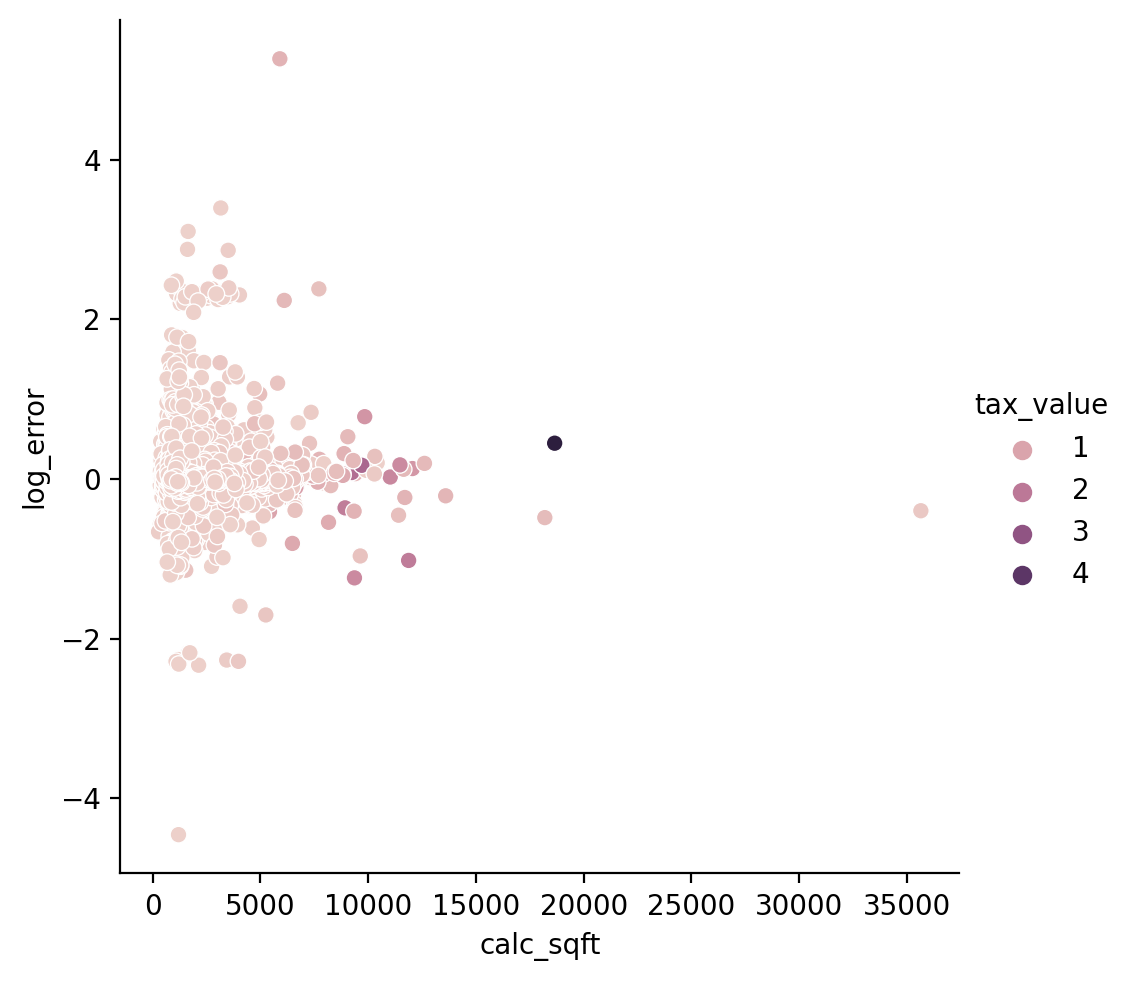

In [3]:

sns.relplot(data=train.sort_values(by='fips'), x='calc_sqft', y='log_error',hue='tax_value')

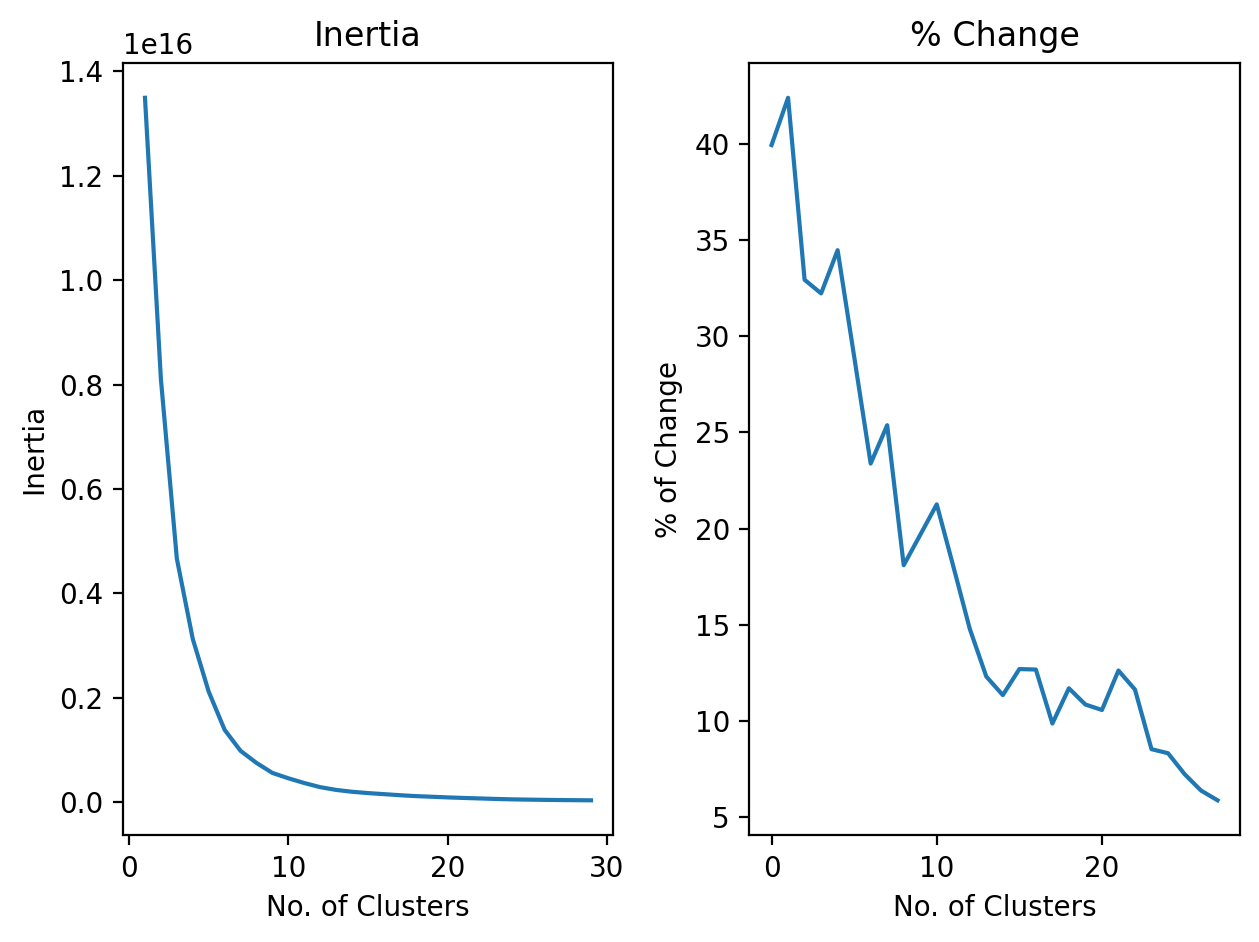

In [4]:
e.generate_elbow(train[['tax_value','calc_sqft']].dropna())

In [5]:
reload(e)
lower_tudes = w.scale(train,['calc_sqft','latitude','longitude'])
e.generate_elbow(lower_tudes,k_min=1,k_max=30)
train.bound_group.value_counts()

3    8780
1    8739
7    4341
0    1501
4     563
2     213
6      58
5      11
Name: tude_cluster, dtype: int64

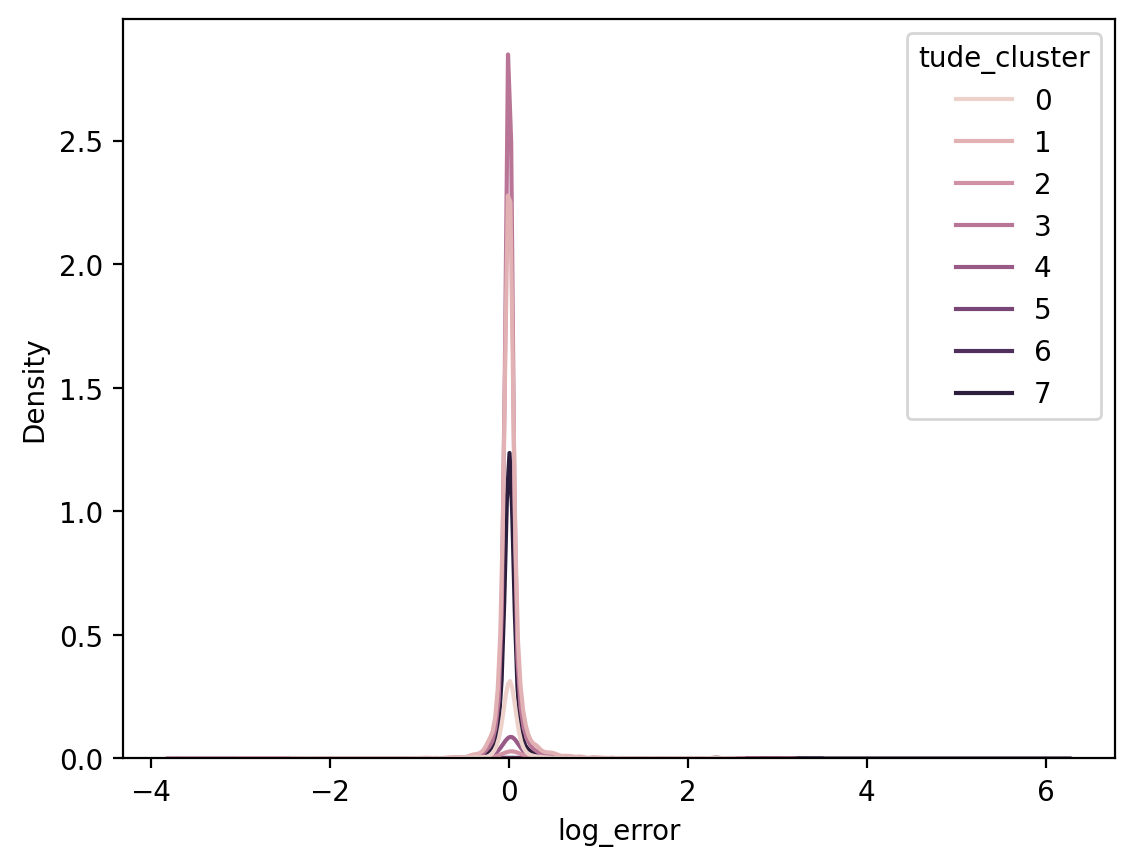

In [ ]:
lower_tudes = w.scale(train,['calc_sqft','tax_value'])
lower_tudes['calc_sqft'] = train['calc_sqft']
lower_tudes['tax_value'] = train['tax_value']
kmeans = KMeans(8)
kmeans.fit(lower_tudes)
lower_tudes['tude_cluster'] = kmeans.predict(lower_tudes)
lower_tudes['log_error'] = train.log_error
lower_tudes['outliers'] = train.outliers
sns.kdeplot(data=lower_tudes, x='log_error',hue='tude_cluster',common_grid=False)
lower_tudes.tude_cluster.value_counts()

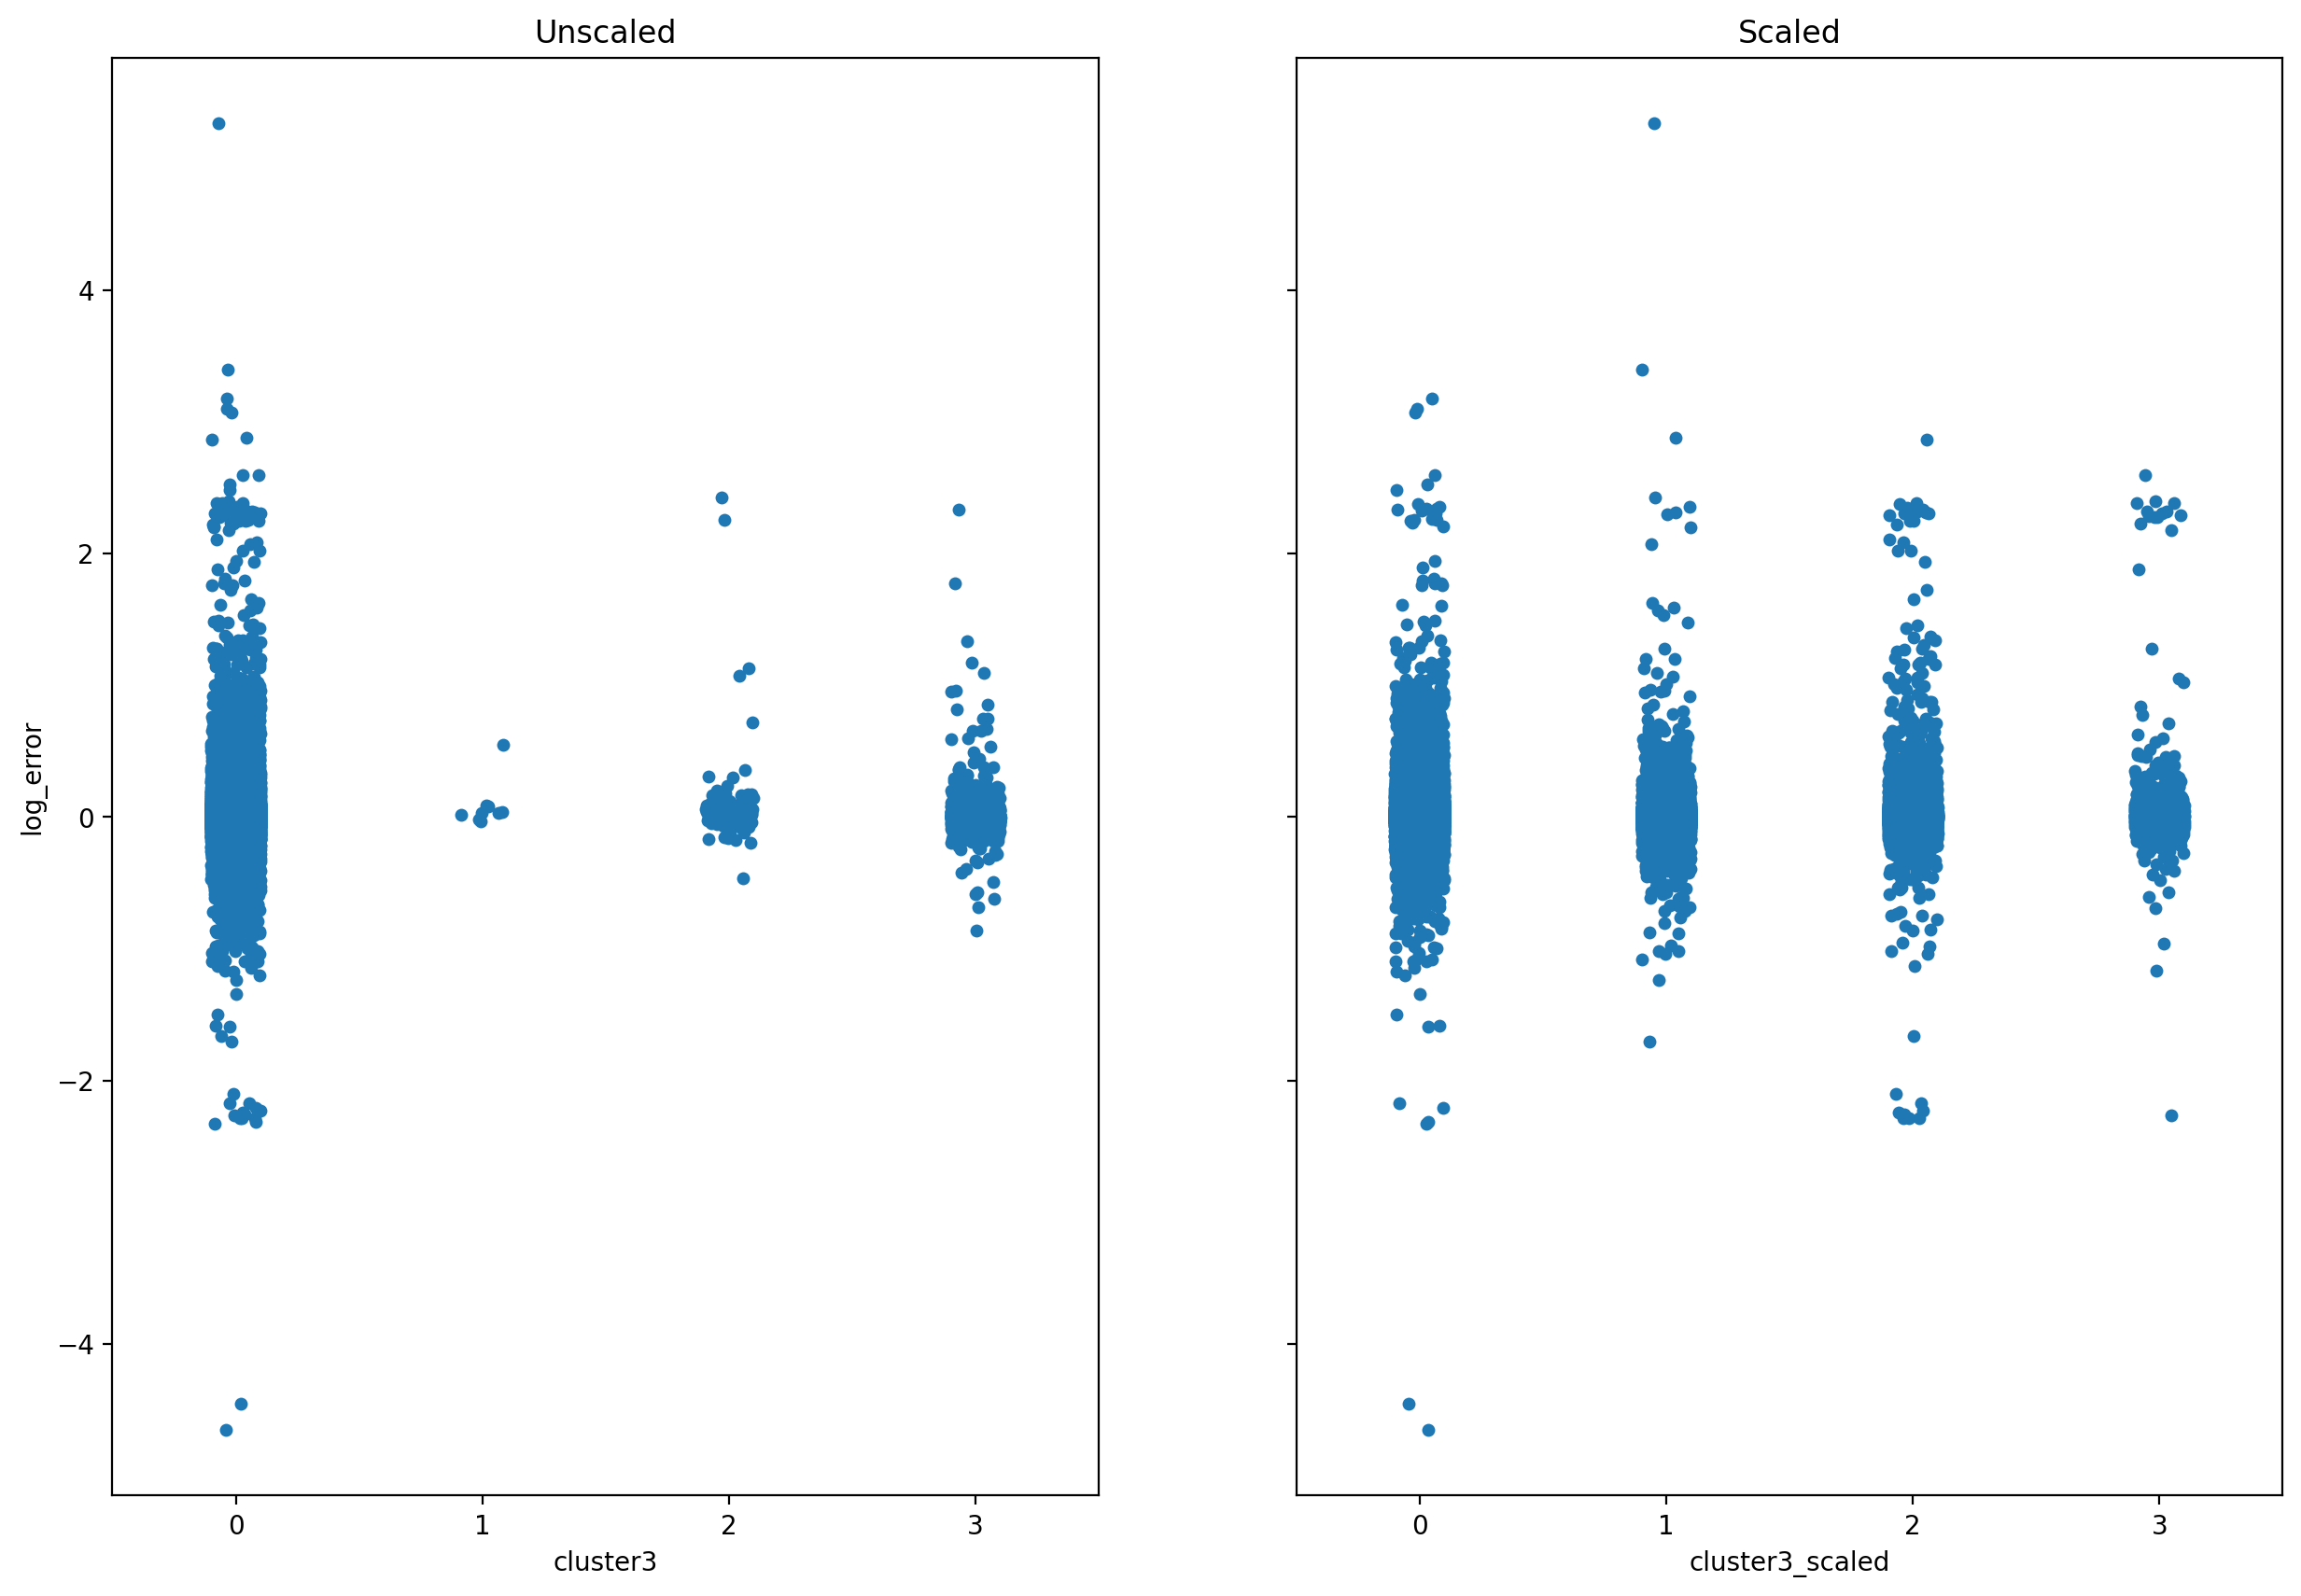

In [ ]:
reload(e)
bound = .5
e.viz_for_Q3(train)

In [ ]:
lower_tudes.groupby('tude_cluster').agg('median').log_error

tude_cluster
0    0.010852
1    0.005812
2    0.024766
3    0.004924
4    0.021015
5   -0.064105
6    0.032814
7    0.007713
Name: log_error, dtype: float64